In [1]:
import os
import re
import json
import time
import logging
import openai
from ibm_watsonx_ai import Credentials, APIClient
from ibm_watsonx_ai.foundation_models import ModelInference
from ibm_watsonx_ai.foundation_models.schema import TextGenParameters
import matplotlib.pyplot as plt
from dotenv import load_dotenv

In [2]:
# Load environment variables from .env.paul
load_dotenv(dotenv_path=".env.paul")

# Get API key from environment
openai.api_key = os.environ.get("OPENAI_API_KEY")
if not openai.api_key:
    raise ValueError("OPENAI_API_KEY not found in .env.paul or environment.")


In [3]:
def create_prompt(sign_name: str) -> str:
    return (
        f"You are an American Sign Language (ASL) teacher.\n\n"
        f"Your task is to explain how to perform the ASL sign for the letter '{sign_name}' in a clear and simple way. Do not assume any prior knowledge about ASL \n\n"
        f"Think step-by-step how to teach the sign for the letter “{sign_name}”. Think about handshape, orientation, and movement of the hand.\n"
        f"Think about the positions of each finger and how they should be held.\n\n"
        f"After thinking, clearly explain how to perform the ASL sign on a beginner level for the letter '{sign_name}'.\n\n"
        f"Only output the explanation for the requested sign once. If appropriate, use less tokens than available. Do not include any other text. Ensure that you exlusively explain the sign for the letter '{sign_name}'\n\n"
    )


In [4]:
def generate_asl_description(sign_name: str, temperature=0.05, max_tokens=300) -> str:
    prompt = create_prompt(sign_name)
    
    response = openai.chat.completions.create(
        model="gpt-4-turbo",
        messages=[
            {"role": "system", "content": "You are an American Sign Language (ASL) teacher."},
            {"role": "user", "content": prompt}
        ],
        temperature=temperature,
        max_tokens=max_tokens
    )
    
    generated_text = response.choices[0].message.content.strip()
    return generated_text


In [5]:
sign = "B"
description = generate_asl_description(sign)
print(f"ASL description for letter '{sign}':\n{description}")


ASL description for letter 'B':
To sign the letter 'B' in American Sign Language (ASL), follow these steps:

1. Start with your dominant hand open and fingers extended, keeping them together.
2. Position your thumb across your palm, so it touches the base of your pinky finger.
3. Ensure your fingers are straight and held together, pointing upwards.
4. Keep your hand facing forward, so your palm is visible to the person you are communicating with.

This is the ASL sign for the letter 'B'.


Judge

In [6]:
# Connect to IBM WatsonX for judge
load_dotenv(dotenv_path=".env.paul")

WX_API_KEY = os.getenv("WX_API_KEY")

credentials = Credentials(
    url="https://us-south.ml.cloud.ibm.com",
    api_key=WX_API_KEY
)

client = APIClient(
    credentials=credentials,
    project_id="68126b74-155e-4a70-aa2c-1781dfad87f6"  # Replace with your actual project ID
)

# Separate model instance for evaluation (judge), we are always using llama-3-3-70b-instruct based on literature review
params = TextGenParameters(
    temperature=0.01,
    max_new_tokens=100,
)


judge_model = ModelInference(
    api_client=client,
    params=params, 
    model_id="meta-llama/llama-3-3-70b-instruct",
)

Mass evaluation

In [7]:
def create_comparison_judge_prompt(sign_name: str, generated_description: str, expected_description: str, guardrails="json") -> str:
    return f"""You are evaluating the quality of a generated ASL sign description based on 3 criteria by comparing it to a ground truth.

Sign: "{sign_name}"

Expected (ground truth) description:
"{expected_description}"

Generated description:
"{generated_description}"

The criteria are:
1. Faithfulness: The content of the generated description can be interfered from the content of the ground truth.
2. Answer Relevance: The generated description specifically and sufficiently describes the requested sign.
3. Context Relevance: The generated description exclusively contains information that is needed to describe the sign.

Grade each criterion from 0 to 1:
- 1 - The generated description fully meets the criterion
- 0.5 - The generated description partially meets the criterion
- 0 - The generated description does not meet the criterion

Do not downgrade the generated description for variation in wording or style. 

Here are a few examples of how to answer:
- example 1:
  - expected description "Thumb: Resting at side or across curled fingers. Index: Bent to form a hook. Middle: Folded into palm. Ring: Folded into palm. Pinky: Folded into palm. Palm Orientation: Facing forward. Movement: None. Note: Hooked finger mimics 'X'."
  - generated description "To sign the letter X in American Sign Language (ASL), make a fist with your dominant hand. Extend your index finger and bend only the tip forward to form a small hook. Face your palm forward so the hooked index finger is visible"
  - response: "faithfulness": 1, "answer_relevance": 1, "context_relevance": 1
- example 2:
  - expected description "Thumb: Resting at side or across curled fingers. Index: Bent to form a hook. Middle: Folded into palm. Ring: Folded into palm. Pinky: Folded into palm. Palm Orientation: Facing forward. Movement: None. Note: Hooked finger mimics 'X'."
  - generated description "Dance in a circle like you never danced before."
  - response: "faithfulness": 0, "answer_relevance": 0, "context_relevance": 0
- example 3:
  - expected description "Thumb: Resting at side or across curled fingers. Index: Bent to form a hook. Middle: Folded into palm. Ring: Folded into palm. Pinky: Folded into palm. Palm Orientation: Facing forward. Movement: None. Note: Hooked finger mimics 'X'."
  - generated description "To sign the letter X in American Sign Language (ASL), make a fist with your dominant hand. Extend your index finger and bend only the tip forward to form a small hook."
  - response: "faithfulness": 1, "answer_relevance": 1, "context_relevance": 1
- example 4:
  - expected description "Thumb: Resting at side or across curled fingers. Index: Bent to form a hook. Middle: Folded into palm. Ring: Folded into palm. Pinky: Folded into palm. Palm Orientation: Facing forward. Movement: None. Note: Hooked finger mimics 'X'."
  - generated description "Hello user, this is a great question. I also love to make the sign for the letter 'X'. To sign the letter X in American Sign Language (ASL), make a fist with your dominant hand. Extend your index finger and bend only the tip forward to form a small hook."
  - response: "faithfulness": 0.5, "answer_relevance": 1, "context_relevance": 0.5
- example 5:
  - expected description Thumb: Resting at side or across curled fingers. Index: Bent to form a hook. Middle: Folded into palm. Ring: Folded into palm. Pinky: Folded into palm. Palm Orientation: Facing forward. Movement: None. Note: Hooked finger mimics 'X'."
  - generated description "To sign the letter X in American Sign Language (ASL), make a fist with your dominant hand and extend your index finger"
  - response: "faithfulness": 1, "answer_relevance": 0.5, "context_relevance": 1
- example 6:
  - expected description "Thumb: Resting at side or across curled fingers. Index: Bent to form a hook. Middle: Folded into palm. Ring: Folded into palm. Pinky: Folded into palm. Palm Orientation: Facing forward. Movement: None. Note: Hooked finger mimics 'X'."
  - generated description "To sign the letter X in American Sign Language (ASL), make a fist with your dominant hand. Extend your index finger and bend only the tip forward to form a small hook. Keep your thumb resting against the side of your curled middle finger. The middle, ring, and pinky fingers stay curled into the palm. There is no movement; the hand remains still"
  - response: "faithfulness": 1, "answer_relevance": 1, "context_relevance": 0.5

Think carefully for each criterion before answering.

Respond only in the following format, enclosed within <output> tags:

<output>
{{
  "faithfulness": <0, 0.5, or 1>,
  "answer_relevance": <0, 0.5, or 1>,
  "context_relevance": <0, 0.5, or 1>
}}
</output>
"""


In [8]:
def evaluate_against_ground_truth(sign_name: str, generated_description: str, expected_description: str) -> dict:
    prompt = create_comparison_judge_prompt(sign_name, generated_description, expected_description)

    def try_parse_response(response_text: str) -> dict:
        result = {
            "faithfulness": None,
            "answer_relevance": None,
            "context_relevance": None
        }

        # Try direct parse
        try:
            # Strip leading text if any
            json_start = response_text.find("{")
            if json_start != -1:
                response_text = response_text[json_start:]

            parsed = json.loads(response_text)
            if isinstance(parsed, dict):
                result.update(parsed)
                return result
        except Exception:
            pass

        # Try fallback regex
        matches = re.findall(r"\{.*?\}", response_text, re.DOTALL)
        for match in matches:
            try:
                parsed = json.loads(match)
                if isinstance(parsed, dict):
                    result.update(parsed)
                    return result
            except Exception as e:
                continue

        return result  # fallback with None values if all fails

    # First attempt
    response = judge_model.generate(prompt=prompt)
    judged_text = response['results'][0]['generated_text']
    result = try_parse_response(judged_text)

    # Retry once if parsing failed
    if any(v is None for v in result.values()):
        print(f" First parse failed for sign '{sign_name}', retrying once...")
        response_retry = judge_model.generate(prompt=prompt)
        judged_text_retry = response_retry['results'][0]['generated_text']
        result = try_parse_response(judged_text_retry)

    # Final message if still failing
    if any(v is None for v in result.values()):
        print(f" Failed to parse JSON after retry for sign: '{sign_name}'.")

    return result


In [9]:
#Testing judge with manual input
sign = "hello"
expected = "Begin with the side of your index finger against your forehead and then move your hand up and away from your head."
generated = "Start with the side of your index touching your forehead"

scores = evaluate_against_ground_truth(sign, generated, expected)

print("\nJudge Result:")
print(f"Faithfulness: {scores['faithfulness']}")
print(f"Answer Relevance: {scores['answer_relevance']}")
print(f"Context Relevance: {scores['context_relevance']}")



Judge Result:
Faithfulness: 0.5
Answer Relevance: 0.5
Context Relevance: 1


In [10]:
test_data = [
    {"sign": "A", "expected": "Thumb: Curled alongside the side of the index finger, resting against it. Index: Bent downward into the palm, creating a firm curve. Middle: Bent downward in line with the index. Ring: Bent downward. Pinky: Bent downward. Palm Orientation: Facing forward (away from your body). Wrist/Forearm: Neutral position; elbow bent naturally. Movement: None. Note: Represents the shape of a capital 'A'."},
    {"sign": "B", "expected": "Thumb: Folded tightly across the center of the palm, held flat. Index: Extended straight up and held close to the middle finger. Middle: Extended straight up next to the index finger. Ring: Extended straight up next to the middle finger. Pinky: Extended straight up, close to the ring finger. Palm Orientation: Facing forward. Wrist/Forearm: Upright, fingers vertical. Movement: None. Note: Resembles the vertical line of the letter 'B'."},
    {"sign": "C", "expected": "Thumb: Curved naturally to oppose the fingers and help form a half-circle. Index: Curved downward and to the side to help form the top of the 'C'. Middle: Curved to follow the shape created by the index. Ring: Curved in alignment with the rest to form the side of the 'C'. Pinky: Curved slightly to close the 'C' shape. Palm Orientation: Slightly angled outward (to mimic letter curvature). Wrist/Forearm: Slight bend at wrist to angle the 'C'. Movement: None. Note: Entire hand forms a visible capital letter 'C'."},
    {"sign": "D", "expected": "Thumb: Pads rest against the tips of the middle, ring, and pinky fingers. Index: Fully extended upward and isolated from other fingers. Middle: Curved downward to meet the thumb. Ring: Curved downward to meet the thumb. Pinky: Curved downward to meet the thumb. Palm Orientation: Facing forward. Wrist/Forearm: Neutral vertical. Movement: None. Note: Mimics the shape of a capital 'D' with the index as the upright line."},
    {"sign": "E", "expected": "Thumb: Pressed against the palm and touching curled fingers from below. Index: Curled downward toward the palm to meet the thumb. Middle: Curled downward toward the palm. Ring: Curled downward toward the palm. Pinky: Curled downward toward the palm. Palm Orientation: Facing forward. Wrist: Neutral or slightly rotated outward. Movement: None. Note: Shape resembles the loop and middle bar of the letter 'E'."},
    {"sign": "F", "expected": "Thumb: Touches tip of the index finger to form a closed circle. Index: Touches the thumb to complete the circle. Middle: Extended straight up and relaxed, slightly separated. Ring: Extended straight up and relaxed, slightly separated. Pinky: Extended straight up and relaxed, slightly separated. Palm Orientation: Facing forward. Wrist: Neutral to slightly outward. Movement: None. Note: The circle represents the opening in the letter 'F'."},
    {"sign": "G", "expected": "Thumb: Extended sideways, parallel to index. Index: Extended sideways, forming a flat, straight line with thumb. Middle: Folded inward against the palm. Ring: Folded inward against the palm. Pinky: Folded inward against the palm. Palm Orientation: Inward (side of hand faces viewer). Wrist: Horizontal; hand like a gun shape. Movement: None. Note: Emulates the lower stroke of a 'G'."},
    {"sign": "H", "expected": "Thumb: Tucked over curled ring and pinky. Index: Extended to the side. Middle: Extended to the side, beside index. Ring: Curled tightly in palm. Pinky: Curled tightly in palm. Palm Orientation: Facing down or slightly out. Wrist: Flat or slightly turned. Movement: None. Note: Represents two parallel lines, like a sideways 'H'."},
    {"sign": "I", "expected": "Thumb: Folded across or tucked alongside curled fingers. Index: Curled into the palm. Middle: Curled into the palm. Ring: Curled into the palm. Pinky: Extended straight up. Palm Orientation: Facing forward. Wrist: Neutral vertical. Movement: None. Note: Pinky alone resembles a lowercase 'i'."},
    {"sign": "J", "expected": "Thumb: Folded against curled fingers. Index: Curled into the palm. Middle: Curled into the palm. Ring: Curled into the palm. Pinky: Extended and used to trace a 'J' in the air. Palm Orientation: Starts forward, rotates slightly. Movement: Trace 'J' downward, left, then up. Note: Motion is essential to identify this as 'J'."},
    {"sign": "K", "expected": "Thumb: Between index and middle fingers, touching base of middle. Index: Extended diagonally upward. Middle: Extended diagonally upward, apart from index. Ring: Curled into palm. Pinky: Curled into palm. Palm Orientation: Facing out or slightly angled. Wrist: Upright or angled. Movement: None. Note: Mimics the open shape of the letter 'K'."},
    {"sign": "L", "expected": "Thumb: Extended horizontally. Index: Extended vertically. Middle: Curled into palm. Ring: Curled into palm. Pinky: Curled into palm. Palm Orientation: Facing forward. Wrist: Upright. Movement: None. Note: Clearly forms a visual 'L'."},
    {"sign": "M", "expected": "Thumb: Tucked under index, middle, and ring fingers. Index: Folded over the thumb. Middle: Folded over the thumb. Ring: Folded over the thumb. Pinky: Curled beside ring or relaxed. Palm Orientation: Facing out. Wrist: Neutral. Movement: None. Note: Three fingers over thumb = 3 strokes = 'M'."},
    {"sign": "N", "expected": "Thumb: Tucked under index and middle fingers. Index: Folded over thumb. Middle: Folded over thumb. Ring: Folded into palm. Pinky: Folded into palm. Palm Orientation: Facing out. Movement: None. Note: Two fingers over thumb = 2 strokes = 'N'."},
    {"sign": "O", "expected": "Thumb: Curved inward to meet fingertips. Index: Curved downward to meet thumb. Middle: Curved downward to meet thumb. Ring: Curved downward to meet thumb. Pinky: Curved downward to meet thumb. Palm Orientation: Facing forward. Wrist: Upright or slightly turned. Movement: None. Note: Clear circular 'O' shape."},
    {"sign": "P", "expected": "Thumb: Between and touching middle finger. Index: Extended downward and slightly angled. Middle: Extended and separated from index. Ring: Folded into the palm. Pinky: Folded into the palm. Palm Orientation: Tilted downward. Wrist: Bent downward. Movement: None. Note: Downward angle distinguishes from K."},
    {"sign": "Q", "expected": "Thumb: Parallel to index. Index: Points downward. Middle: Curled into palm. Ring: Curled into palm. Pinky: Curled into palm. Palm Orientation: Downward. Wrist: Bent downward. Movement: None. Note: Like G but rotated to point down."},
    {"sign": "R", "expected": "Thumb: Resting against curled fingers. Index: Crossed over middle finger tightly. Middle: Crossed under index. Ring: Folded into palm. Pinky: Folded into palm. Palm Orientation: Facing forward. Movement: None. Note: Finger crossing symbolizes 'R'."},
    {"sign": "S", "expected": "Thumb: Crossed tightly over the front of curled fingers. Index: Curled into a fist. Middle: Curled into a fist. Ring: Curled into a fist. Pinky: Curled into a fist. Palm Orientation: Facing forward. Wrist: Upright. Movement: None. Note: Fist shape resembles bold 'S'."},
    {"sign": "T", "expected": "Thumb: Inserted between index and middle fingers. Index: Curled downward over the thumb. Middle: Curled downward over the thumb. Ring: Curled into the palm. Pinky: Curled into the palm. Palm Orientation: Facing forward. Movement: None. Note: Thumb poking between fingers resembles old-style 'T'."},
    {"sign": "U", "expected": "Thumb: Folded against palm. Index: Extended straight upward. Middle: Extended straight upward, held together with index. Ring: Folded into the palm. Pinky: Folded into the palm. Palm Orientation: Facing forward. Movement: None. Note: Two fingers = 2 strokes of 'U'."},
    {"sign": "V", "expected": "Thumb: Folded in or at side. Index: Extended upward. Middle: Extended upward, spread apart from index. Ring: Folded into palm. Pinky: Folded into palm. Palm Orientation: Facing forward. Movement: None. Note: Clear 'V' shape."},
    {"sign": "W", "expected": "Thumb: Tucked or relaxed. Index: Extended upward. Middle: Extended upward. Ring: Extended upward, spread slightly. Pinky: Folded into the palm. Palm Orientation: Facing forward. Movement: None. Note: Three fingers = 'W'."},
    {"sign": "X", "expected": "Thumb: Resting at side or across curled fingers. Index: Bent to form a hook. Middle: Folded into palm. Ring: Folded into palm. Pinky: Folded into palm. Palm Orientation: Facing forward. Movement: None. Note: Hooked finger mimics 'X'."},
    {"sign": "Y", "expected": "Thumb: Extended sideways. Index: Folded into palm. Middle: Folded into palm. Ring: Folded into palm. Pinky: Extended in opposite direction from thumb. Palm Orientation: Facing forward. Movement: None. Note: Thumb and pinky spread = 'Y' shape."},
    {"sign": "Z", "expected": "Thumb: Folded against curled fingers or at the side. Index: Extended and used to draw a 'Z' in the air. Middle: Curled into palm. Ring: Curled into palm. Pinky: Curled into palm. Palm Orientation: Faces slightly forward, rotating with the movement. Movement: Trace 'Z' in air from top-left to bottom-right."}
]


In [11]:
# Store all scores
all_scores = []

# counter to indictae progress of the evaluation
i=0

for entry in test_data:
    i=i+1
    print(f"\n{i}. Evaluating sign: {entry['sign']}")
    sign = entry["sign"]
    expected = entry["expected"]

    # Generate from LLM
    generated = generate_asl_description(sign)

    # Judge against expected
    scores = evaluate_against_ground_truth(sign, generated, expected)

    all_scores.append(scores)

# Compute and print average for each metric
print("\nAverage Scores:")
faithfulness_avg = sum(s["faithfulness"] for s in all_scores if s["faithfulness"] is not None) / len(all_scores)
print(f"Faithfulness: {faithfulness_avg:.2f}")
relevance_avg = sum(s["answer_relevance"] for s in all_scores if s["answer_relevance"] is not None) / len(all_scores)
print(f"Answer Relevance: {relevance_avg:.2f}")
context_avg = sum(s["context_relevance"] for s in all_scores if s["context_relevance"] is not None) / len(all_scores)
print(f"Context Relevance: {context_avg:.2f}")


1. Evaluating sign: A

2. Evaluating sign: B

3. Evaluating sign: C

4. Evaluating sign: D

5. Evaluating sign: E

6. Evaluating sign: F

7. Evaluating sign: G

8. Evaluating sign: H

9. Evaluating sign: I

10. Evaluating sign: J

11. Evaluating sign: K

12. Evaluating sign: L

13. Evaluating sign: M

14. Evaluating sign: N

15. Evaluating sign: O

16. Evaluating sign: P

17. Evaluating sign: Q

18. Evaluating sign: R

19. Evaluating sign: S

20. Evaluating sign: T

21. Evaluating sign: U

22. Evaluating sign: V

23. Evaluating sign: W

24. Evaluating sign: X

25. Evaluating sign: Y

26. Evaluating sign: Z

Average Scores:
Faithfulness: 0.69
Answer Relevance: 0.96
Context Relevance: 0.75


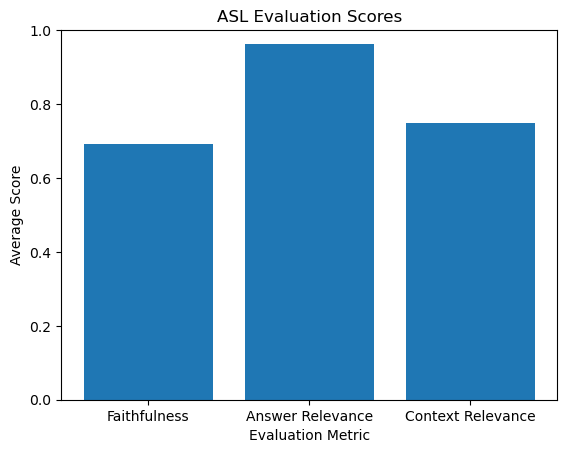

In [12]:
# Plot
labels = ["Faithfulness", "Answer Relevance", "Context Relevance"]
values = [faithfulness_avg, relevance_avg, context_avg]

_, ax = plt.subplots()
ax.bar(labels, values)
ax.set_ylim(0, 1)
ax.set_ylabel("Average Score")
ax.set_xlabel("Evaluation Metric")
ax.set_title("ASL Evaluation Scores")
plt.show()